# 데이터 전처리

In [2]:
#라벨 추출
from sklearn.model_selection import train_test_split
labels=[]
allFileList = os.listdir(path)
for i, file in enumerate(allFileList):
    fileName, gender, age, label, place, _ = file.split('_') # 추후 연구에서 gender나 age 등 다양한 자료로 활용 가능
    labels.append(label)
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(allFileList, labels, test_size=0.3, shuffle=True, random_state=10)

In [3]:
def get_key(val):
  if val == "기쁨":
      re = 0
  elif val == "당황":
      re = 1
  elif val == "분노":
      re = 2
  elif val == "불안":
      re = 3
  elif val == "슬픔":
      re = 4
  else:
      print("label error")
  return re

In [7]:
#트레인 셋 리사이징, 얼굴인식, 데이터 로더 
for i, file in enumerate(x_train):
    try:
        img = plt.imread(path+file)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Shap model이 3채널에서만 작동하여 생략
    
        if (i%1000 == 0):
            print(i,"/",len(x_train))
        results = cascade.detectMultiScale(img, scaleFactor= 1.3, minNeighbors=5, minSize=(100,100))
        flag=True
        if len(results): 
            for box in results:
                x, y, w, h = box
                cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2) #이미지파일, 시작점좌표, 끝나는점 좌표, 윤곽선 색, 선 굵기
                img = img[y:y+h, x:x+w]
            try:
                img = cv2.resize(img, (96,96))
            except:
                flag=False
        else:
            continue

        if flag==False:
            continue
        img = img_to_array(img)
        img = img.reshape((1,)+img.shape)
        label2=unicodedata.normalize('NFC',y_train[i])
    #except:
    #    continue
        if i == 0 :
            container_train = img
            labels_train = get_key(label2)
        else:
            container_train = np.vstack([container_train, img])
            labels_train = np.vstack([labels_train, get_key(label2)])
    except:
        continue
        
xTrain = container_train
yTrain = np_utils.to_categorical(labels_train,5)

0 / 56418


In [4]:
#테스트 셋 리사이징, 얼굴인식, 데이터 로더 
for i, file in enumerate(x_test):
    img = plt.imread(path+file)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    results = cascade.detectMultiScale(img, scaleFactor= 1.3, minNeighbors=5, minSize=(100,100))
    flag=True
    if (i %1000)==0:
        print(i,len(x_test))
    if len(results):  
        for box in results:
            x, y, w, h = box
            cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2) #이미지파일, 시작점좌표, 끝나는점 좌표, 윤곽선 색, 선 굵기
            img = img[y:y+h, x:x+w]
            try:
                img = cv2.resize(img, (96,96))
            except:
                flag=False
    else:
        continue
    
    if flag==False:
        continue
    img = img_to_array(img)
    img = img.reshape((1,)+img.shape)
    label2=unicodedata.normalize('NFC',y_test[i])

    if i == 0 :
        container_test = img
        labels_test = get_key(label2)
    else:
        container_test = np.vstack([container_test, img])
        labels_test = np.vstack([labels_test, get_key(label2)])

xTest = container_test
yTest = np_utils.to_categorical(labels_test,5)   

0 24180
1000 24180
2000 24180
3000 24180
4000 24180
5000 24180
6000 24180
7000 24180
8000 24180
9000 24180
10000 24180
11000 24180
12000 24180
13000 24180
14000 24180
15000 24180
16000 24180
17000 24180
18000 24180
19000 24180
20000 24180
21000 24180
22000 24180
23000 24180
24000 24180


# 원본데이터 분류모델

In [12]:
class_names = ['기쁨', '당황', '분노', '불안', '슬픔']
def get_value(key):
    if key == 0:
        re = "기쁨"
    elif key == 1:
        re = "당황"
    elif key == 2:
        re = "분노"
    elif key == 3:
        re = "불안"
    elif key == 4:
        re = "슬픔"
    else:
        print("key error")
    return re

In [1]:
import numpy as np
import cv2
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import unicodedata
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
import datetime
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow.compat.v1.keras.backend as K 
import tensorflow as tf 
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

plt.rc('font', family='Malgun Gothic')

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
# 가중치 파일 경로
# cascade_filename = 'C:/Users\k/Downloads/haarcascade_frontalface_alt.xml'
# # # 모델 불러오기
# cascade = cv2.CascadeClassifier(cascade_filename)
# path = 'E:/원천data/한국인 감정인식을 위한 복합 영상/Training/'

In [5]:
with open('train_origin.p', 'rb') as file: 
    xTrain = pickle.load(file)
    yTrain = pickle.load(file)
    #contain_train =pickle.load(file)
    #labels_train = pickle.load(file)

In [4]:
with open('test_origin.p', 'rb') as file:   
    xTest = pickle.load(file)
    yTest = pickle.load(file)
    #contain_test =pickle.load(file)
    #labels_test = pickle.load(file)

In [8]:
#validation set
xVal = xTrain[-5000:]
yVal = yTrain[-5000:]
xTrain = xTrain[:-5000]
yTrain = yTrain[:-5000]

In [9]:
#데이터 정규화
xTrain = xTrain.astype('float32')/255
xVal = xVal.astype('float32')/255
xTest = xTest.astype('float32')/255
y_classes = np.argmax(yTest, axis=1)

In [3]:
#GPU 메모리 점진적 할당

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [7]:
epochs=20
batch_size=128

In [3]:
#모델 정의/학습 - 원본 데이터

with tf.device('/gpu:0'):
    model2 = Sequential()
    model2.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(96,96,3)))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(128, kernel_size=(5,5),padding='same'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(512, kernel_size=(3,3),padding='same'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))
               
    model2.add(Conv2D(512, kernel_size=(3,3),padding='same', activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Flatten())
               
    model2.add(Dense(256))
    model2.add(BatchNormalization())               
    model2.add(Activation('relu'))
    model2.add(Dropout(0.25))

    model2.add(Dense(256))
    model2.add(BatchNormalization())               
    model2.add(Activation('relu'))
    model2.add(Dropout(0.25))
    
    opt = Adam(learning_rate=0.0005)
    model2.add(Dense(5, activation='softmax'))
    model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
#     history2 = model2.fit(xTrain, yTrain, validation_data=(xVal, yVal),
#                       epochs=epochs, batch_size=batch_size)


In [4]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)      

In [6]:
#모델 저장
model2.save("FER_CNN")

INFO:tensorflow:Assets written to: FER_CNN\assets


In [20]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 128)       204928    
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 128)      

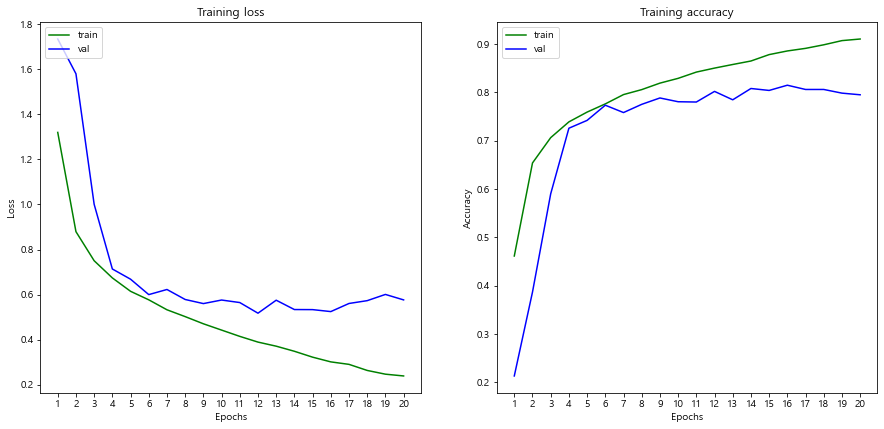

In [10]:
#batch 128, epoch 20
epoch=range(1,epochs+1)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1,16)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)

plt.plot(epoch, loss_train, 'g', label='Training loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')

plt.xticks(epoch)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')


loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']
epochs = range(1,16)
plt.subplot(2,2,2)

plt.plot(epoch, loss_train, 'g', label='Training accuracy')
plt.plot(epoch, loss_val, 'b', label='validation accuracy')
plt.xticks(epoch)
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

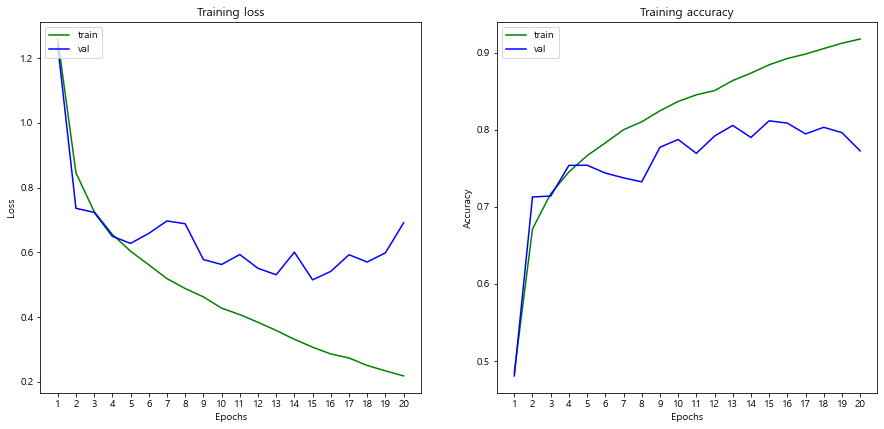

In [9]:
#batch 64, epoch 20
epoch=range(1,epochs+1)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1,16)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)

plt.plot(epoch, loss_train, 'g', label='Training loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')

plt.xticks(epoch)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')


loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']
epochs = range(1,16)
plt.subplot(2,2,2)

plt.plot(epoch, loss_train, 'g', label='Training accuracy')
plt.plot(epoch, loss_val, 'b', label='validation accuracy')
plt.xticks(epoch)
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [2]:
model2 = keras.models.load_model('FER_CNN')

In [10]:
#모델 정확도 #batch=64, epoch =20
predict_x=model2.predict(xTest) 
classes_x=np.argmax(predict_x,axis=1)
accuracy_score(y_classes, classes_x)

0.7730954913673186

In [11]:
#모델 정확도 #batch=128, epoch =20
predict_x=model2.predict(xTest) 
classes_x=np.argmax(predict_x,axis=1)
accuracy_score(y_classes, classes_x)

0.7857785778577858

In [19]:
y_classes

array([2, 3, 1, ..., 3, 3, 3], dtype=int64)

In [17]:
print(classification_report(target, predicted))

              precision    recall  f1-score   support

          기쁨       0.93      0.93      0.93      2460
          당황       0.83      0.75      0.79      2416
          분노       0.78      0.81      0.79      2405
          불안       0.64      0.67      0.66      2533
          슬픔       0.79      0.80      0.79      2407

    accuracy                           0.79     12221
   macro avg       0.79      0.79      0.79     12221
weighted avg       0.79      0.79      0.79     12221



In [13]:
predicted=[]
target=[]
for i in range(len(classes_x)):
    tmp = get_value(classes_x[i])
    tmp2 = get_value(y_classes[i])
    predicted.append(tmp)
    target.append(tmp2)
#predicted=get_value(classes_x)

[Text(0, 0.5, '기쁨'),
 Text(0, 1.5, '당황'),
 Text(0, 2.5, '분노'),
 Text(0, 3.5, '불안'),
 Text(0, 4.5, '슬픔')]

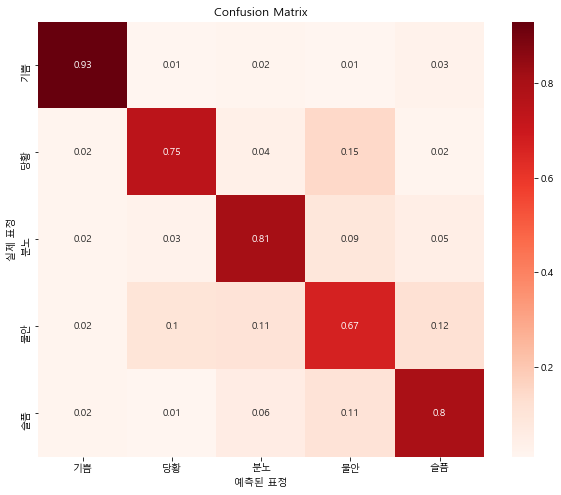

In [16]:
matrix = confusion_matrix(target, predicted)
matrix_percentage=np.round(matrix / matrix.astype(np.float).sum(axis=1),2)

plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(matrix_percentage, annot=True, fmt='g', ax=ax, cmap='Reds')

ax.set_xlabel('예측된 표정');ax.set_ylabel('실제 표정');
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(class_names) 
ax.yaxis.set_ticklabels(class_names)

# 정제된 모델 평가

In [1]:
import numpy as np
import cv2
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import unicodedata
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
import datetime
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow.compat.v1.keras.backend as K 
import tensorflow as tf 
import pickle
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()
# 가중치 파일 경로
# cascade_filename = 'C:/Users\k/Downloads/haarcascade_frontalface_alt.xml'
# # # 모델 불러오기
# cascade = cv2.CascadeClassifier(cascade_filename)
# path = 'E:/원천data/한국인 감정인식을 위한 복합 영상/Training/'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#정제된 데이터 로드
with open('train_new.p', 'rb') as file: 
    
    new_x= pickle.load(file)
    new_y= pickle.load(file)

In [3]:
#테스트셋 로드
with open('test_origin.p', 'rb') as file:   
    xTest = pickle.load(file)
    yTest = pickle.load(file)

In [4]:
new_val_x = new_x[-5000:]
new_val_y = new_y[-5000:]
new_x = new_x[:-5000]
new_y = new_y[:-5000]

In [5]:
xTest = xTest.astype('float32')/255
y_classes = np.argmax(yTest, axis=1)

In [6]:
epochs=20
batch_size=128

In [7]:

with tf.device('/gpu:0'):
    model2 = Sequential()
    model2.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(96,96,3)))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(128, kernel_size=(5,5),padding='same'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(512, kernel_size=(3,3),padding='same'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))
               
    model2.add(Conv2D(512, kernel_size=(3,3),padding='same', activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Flatten())
               
    model2.add(Dense(256))
    model2.add(BatchNormalization())               
    model2.add(Activation('relu'))
    model2.add(Dropout(0.25))

    model2.add(Dense(256))
    model2.add(BatchNormalization())               
    model2.add(Activation('relu'))
    model2.add(Dropout(0.25))
    
    opt = Adam(learning_rate=0.0005)
    model2.add(Dense(5, activation='softmax'))
    model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    history2 = model2.fit(new_x, new_y, validation_data=(new_val_x, new_val_y),
                      epochs=epochs, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Train on 17379 samples, validate on 5000 samples
Epoch 1/20
17379/17379 [==============================] - ETA: 0s - loss: 1.3972 - acc: 0.4233

C:\Users\k\.conda\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


17379/17379 [==============================] - 25s 1ms/sample - loss: 1.3972 - acc: 0.4233 - val_loss: 1.6840 - val_acc: 0.2088
Epoch 2/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.9469 - acc: 0.6160 - val_loss: 1.7380 - val_acc: 0.2398
Epoch 3/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.7938 - acc: 0.6913 - val_loss: 1.1260 - val_acc: 0.5442
Epoch 4/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.7119 - acc: 0.7205 - val_loss: 0.9554 - val_acc: 0.6026
Epoch 5/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.6466 - acc: 0.7526 - val_loss: 0.7663 - val_acc: 0.6962
Epoch 6/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.5951 - acc: 0.7713 - val_loss: 0.7862 - val_acc: 0.6854
Epoch 7/20
17379/17379 [==============================] - 18s 1ms/sample - loss: 0.5584 - acc: 0.7832 - val_loss: 0.6645 - val_acc: 0.7430
Epoch 8/20
17379/17379 [==============

In [34]:
#모델 저장
model2.save("Improved_FER_CNN")

OSError: Unable to create file (unable to open file: name = 'Improved_FER_CNN', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [7]:
#모델 로드
model2 = keras.models.load_model('Improved_FER_CNN')

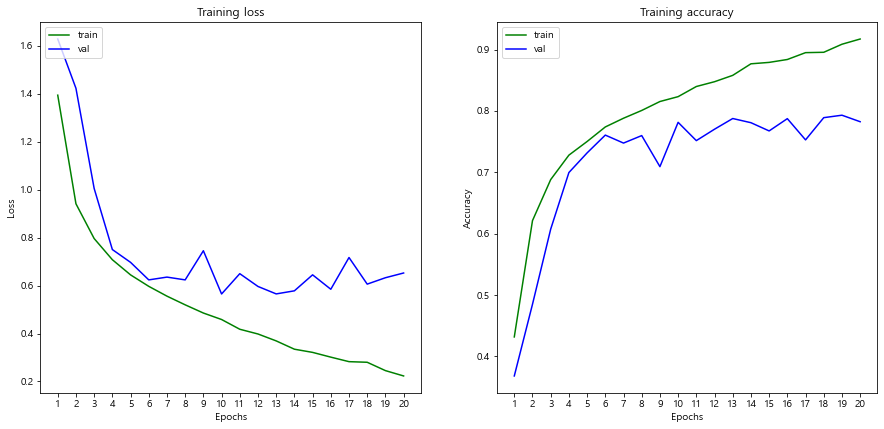

In [13]:
 #batch = 64 epoch = 20
#모델 훈련 시각화
epoch=range(1,epochs+1)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)

plt.plot(epoch, loss_train, 'g', label='Training loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')

plt.xticks(epoch)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')


loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']
plt.subplot(2,2,2)

plt.plot(epoch, loss_train, 'g', label='Training accuracy')
plt.plot(epoch, loss_val, 'b', label='validation accuracy')
plt.xticks(epoch)
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

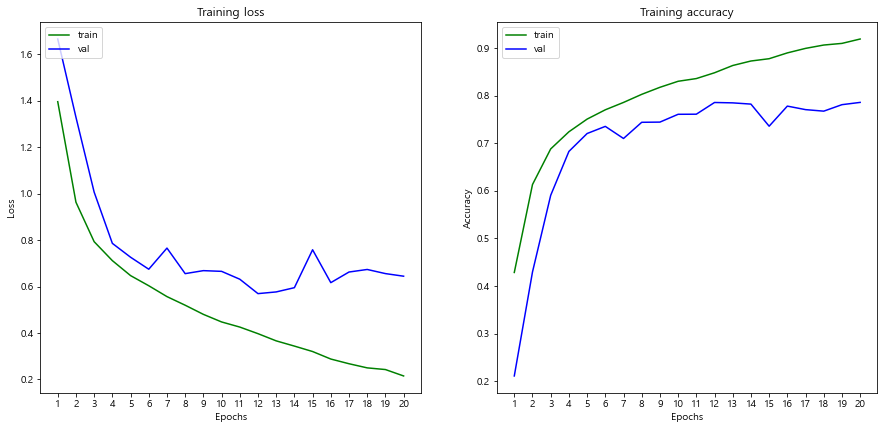

In [9]:
#모델 훈련 시각화 #batch = 128 epoch = 20
epoch=range(1,epochs+1)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)

plt.plot(epoch, loss_train, 'g', label='Training loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')

plt.xticks(epoch)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')


loss_train = history2.history['accuracy']
loss_val = history2.history['val_accuracy']
plt.subplot(2,2,2)

plt.plot(epoch, loss_train, 'g', label='Training accuracy')
plt.plot(epoch, loss_val, 'b', label='validation accuracy')
plt.xticks(epoch)
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
#batch=64 epoch=20
predict_x=model2.predict(xTest) 
classes_x=np.argmax(predict_x,axis=1)
accuracy_score(y_classes, classes_x)

0.7880697160625153

In [23]:
#batch=128 epoch=20
predict_x=model2.predict(xTest) 
classes_x=np.argmax(predict_x,axis=1)
accuracy_score(y_classes, classes_x)

0.7987071434416169

In [ ]:
#batch=128 epoch=20
predict_x=model2.predict(xTest) 
classes_x=np.argmax(predict_x,axis=1)
accuracy_score(y_classes, classes_x)

In [27]:
#분류 리포트
from sklearn.metrics import classification_report
new_predicted=[]
new_target=[]
for i in range(len(classes_x)):
    tmp = get_value(classes_x[i])
    tmp2 = get_value(y_classes[i])
    new_predicted.append(tmp)
    new_target.append(tmp2)
#predicted=get_value(classes_x)

print(classification_report(new_target, new_predicted))

              precision    recall  f1-score   support

          기쁨       0.89      0.95      0.92      2460
          당황       0.87      0.71      0.78      2416
          분노       0.79      0.82      0.80      2405
          불안       0.66      0.70      0.68      2533
          슬픔       0.80      0.82      0.81      2407

    accuracy                           0.80     12221
   macro avg       0.80      0.80      0.80     12221
weighted avg       0.80      0.80      0.80     12221



[Text(0, 0.5, '기쁨'),
 Text(0, 1.5, '당황'),
 Text(0, 2.5, '분노'),
 Text(0, 3.5, '불안'),
 Text(0, 4.5, '슬픔')]

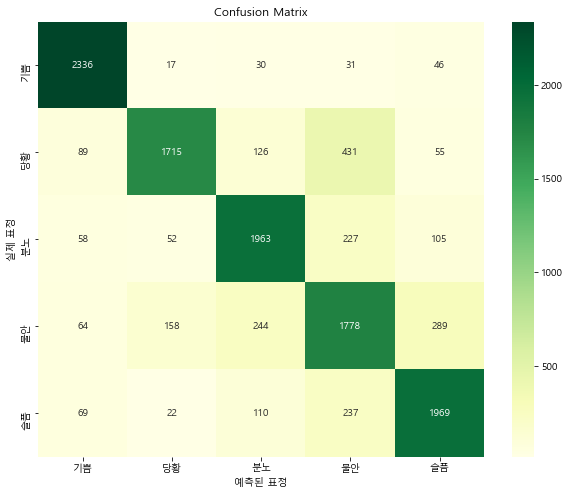

In [33]:
#Confusion matrix
import seaborn as sns

plt.figure(figsize=(10,8))
matrix = confusion_matrix(new_target, new_predicted)

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='YlGn')

ax.set_xlabel('예측된 표정');ax.set_ylabel('실제 표정');
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(class_names) 
ax.yaxis.set_ticklabels(class_names)

In [50]:
#Garbage collect
import gc
gc.collect()

array([[[0.8       , 0.7882353 , 0.7294118 ],
        [0.7882353 , 0.7764706 , 0.7176471 ],
        [0.7882353 , 0.7647059 , 0.70980394],
        ...,
        [0.80784315, 0.7921569 , 0.74509805],
        [0.7882353 , 0.77254903, 0.7254902 ],
        [0.81960785, 0.8039216 , 0.75686276]],

       [[0.8235294 , 0.8       , 0.75686276],
        [0.7882353 , 0.7764706 , 0.7176471 ],
        [0.8156863 , 0.7921569 , 0.73333335],
        ...,
        [0.7764706 , 0.7607843 , 0.7137255 ],
        [0.827451  , 0.8117647 , 0.7647059 ],
        [0.827451  , 0.8117647 , 0.7647059 ]],

       [[0.827451  , 0.8117647 , 0.7529412 ],
        [0.8039216 , 0.78039217, 0.7254902 ],
        [0.8392157 , 0.827451  , 0.76862746],
        ...,
        [0.8117647 , 0.79607844, 0.7490196 ],
        [0.80784315, 0.7921569 , 0.74509805],
        [0.8156863 , 0.8       , 0.7529412 ]],

       ...,

       [[0.1254902 , 0.10588235, 0.10196079],
        [0.14901961, 0.11372549, 0.11764706],
        [0.12156863, 0

# SHAP 정의 -  tensoflow 2.0이상 지원안함

In [7]:
#Shap 정의
import shap
background = xTrain[np.random.choice(xTrain.shape[0], 100, replace=False)]
#background = xTrain[:200]
#explainer = shap.GradientExplainer(model, [xTrain, xTrain])

# we explain the model's predictions on the first three samples of the test set
#shap_values = explainer.shap_values([xTest[0], xTest[0]])

# # explain predictions of the model on four images
e = shap.DeepExplainer(model2, background)
# # ...or pass tensors directly
#e = shap.DeepExplainer((model2.layers[0].input, model2.layers[-1].output), background)
#shap_values, idx = e.shap_values(xTest[:10],ranked_outputs=5,check_additivity= False)
#shap_values = e.shap_values(xTest)
#shap_values, idx = e.shap_values(xTest[:10])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [13]:
#GPU 메모리 반환
from tensorflow.keras import backend as K
curr_session = tf.compat.v1.get_default_session()
# close current session
if curr_session is not None:
    curr_session.close()
# reset graph
K.clear_session()
# create new session
s = tf.compat.v1.InteractiveSession
tf.compat.v1.keras.backend.set_session(s)

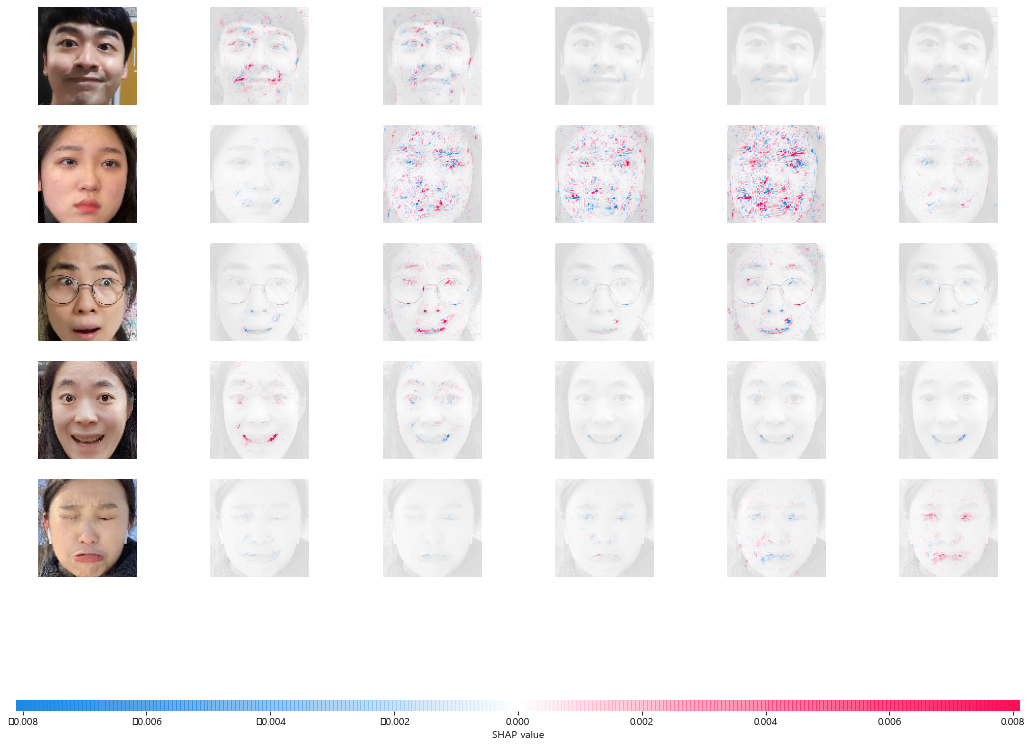

In [22]:
shap_values = e.shap_values(xTrain[5:9])
shap.image_plot(shap_values, xTrain[5:10])

In [465]:
# 데이터 별 Shap value 추출
shap_value = e.shap_values(xTrain)
shap_values = np.array(shap_value)

In [466]:
y_classes = np.argmax(yTrain, axis=1)

In [467]:
#라벨과 맞는 shap value만 추출
shap_list=[]
for i,y in enumerate(xTrain):
    shap_list.append(shap_values[y_classes[i]][i])

In [468]:
# shap value 상위 2% 추출
anom_97=[]

def importantPixel(shap_v):
    #abs_shap = np.absolute(shap_v)
    upper3 = np.percentile(shap_v,97)
    anom_97.append(upper3)
    arr = np.array(anom_97)
    return arr.mean()
shap_mean = importantPixel(shap_list)
shap_mean

0.0013229705870617166

In [469]:
# 상위 2%이상의 shap value가 단 하나도 없는 데이터 추출
anom_label=[]
anomaly_idx=[]
def outlier(shap_v, x):
    #abs_shap = np.absolute(shap_v)
    upper_idx=np.where(shap_v>shap_mean)
    #lower_idx=np.where(shap_v<lower,shap_v,0)
    #weight_up=np.where(upper_idx!=0,shap_v,0)
    #weight_low=np.where(lower_idx!=0,x,0)
    #dst = cv2.addWeighted(weight_up, 0.2, x, 1, 0)
    #dst_sharp = cv2.filter2D(src=weight_up, ddepth=-1, kernel=kernel)
    #dst = weight_r_p
    #dst = np.where(unsharp_dst==0,x,unsharp_dst)
    if np.all(abs_shap[upper_idx]==0):
        anom_label.append(y_classes[i])
        anomaly_idx.append(j)


In [470]:
# 주요픽셀이 없는 데이터의 인덱스 추출
anom=[]
for i in range(len(shap_list)):
    j= i
    r=xTrain[j][:,:,0]
    g=xTrain[j][:,:,1]
    b=xTrain[j][:,:,2]
    shap_r = shap_list[i][:,:,0]
    shap_g = shap_list[i][:,:,1]
    shap_b = shap_list[i][:,:,2]
    #shap_r_abs=
    #shap_g_abs=np.absolute(shap_g)
    #shap_b_abs=np.absolute(shap_b)
    outlier(shap_r,r)
    outlier(shap_g,g)
    outlier(shap_b,b)
    
anomaly_idx=set(anomaly_idx)
anom = xTrain[list(anomaly_idx)]
#     dst=cv2.merge((dst_r,dst_g,dst_b))
#     inv.append(dst)
# arr = np.array(inv)
# arr.shape   
len(anom)

10

In [471]:
c=np.append(a,list(anomaly_idx))

In [472]:
final_idx = np.array(c)

In [473]:
np.save('anomaly_list.npy',final_idx)

In [3]:
a= np.load('anomaly_list.npy')
a

array([   15,    86,    95, ..., 27798, 28380, 27517])

In [17]:
new_x = np.delete(xTrain,a,axis=0)
new_y = np.delete(yTrain,a,axis=0)

In [15]:
np.save('sorted_anom.npy',new)

array([[[159., 134., 105.],
        [128., 108.,  81.],
        [115.,  98.,  72.],
        ...,
        [108.,  91.,  77.],
        [136., 117., 104.],
        [110.,  99.,  89.]],

       [[130., 110.,  85.],
        [120., 102.,  78.],
        [107.,  91.,  66.],
        ...,
        [105.,  87.,  72.],
        [142., 122., 113.],
        [129., 115., 104.]],

       [[121., 104.,  74.],
        [112.,  96.,  73.],
        [121., 107.,  80.],
        ...,
        [101.,  81.,  69.],
        [120., 101.,  87.],
        [126., 106.,  91.]],

       ...,

       [[ 97.,  83.,  53.],
        [114.,  97.,  65.],
        [110.,  95.,  62.],
        ...,
        [152., 154., 148.],
        [127., 121., 104.],
        [146., 129., 109.]],

       [[ 99.,  89.,  61.],
        [114., 101.,  67.],
        [122., 112.,  80.],
        ...,
        [176., 183., 176.],
        [167., 164., 148.],
        [156., 138., 119.]],

       [[129., 120.,  89.],
        [104.,  93.,  61.],
        [128., 1

In [42]:
#노이즈 데이터
with open('train_new.p', 'wb') as file: 
    pickle.dump(new_x, file)
    pickle.dump(new_y, file)

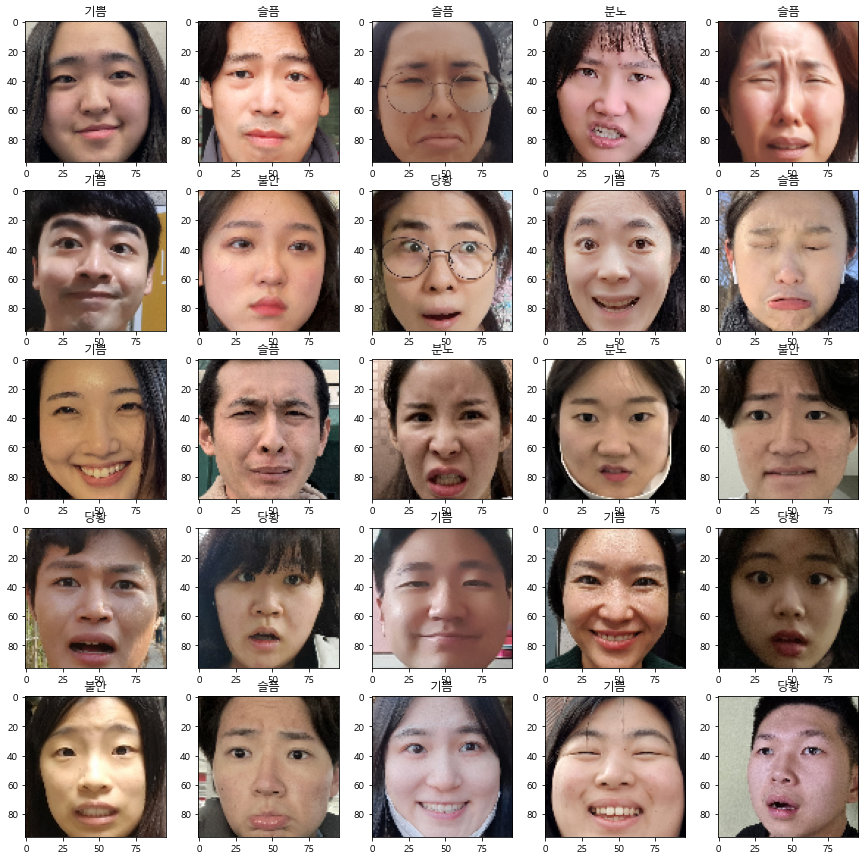

In [36]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
#fig.subtitle("Anomaly data",fontsize=16)
for i,ax in enumerate(axes.flat):
    tmp = get_value(y_classes[i])
    ax.title.set_text(tmp)
    ax.imshow(new_x[i])
 

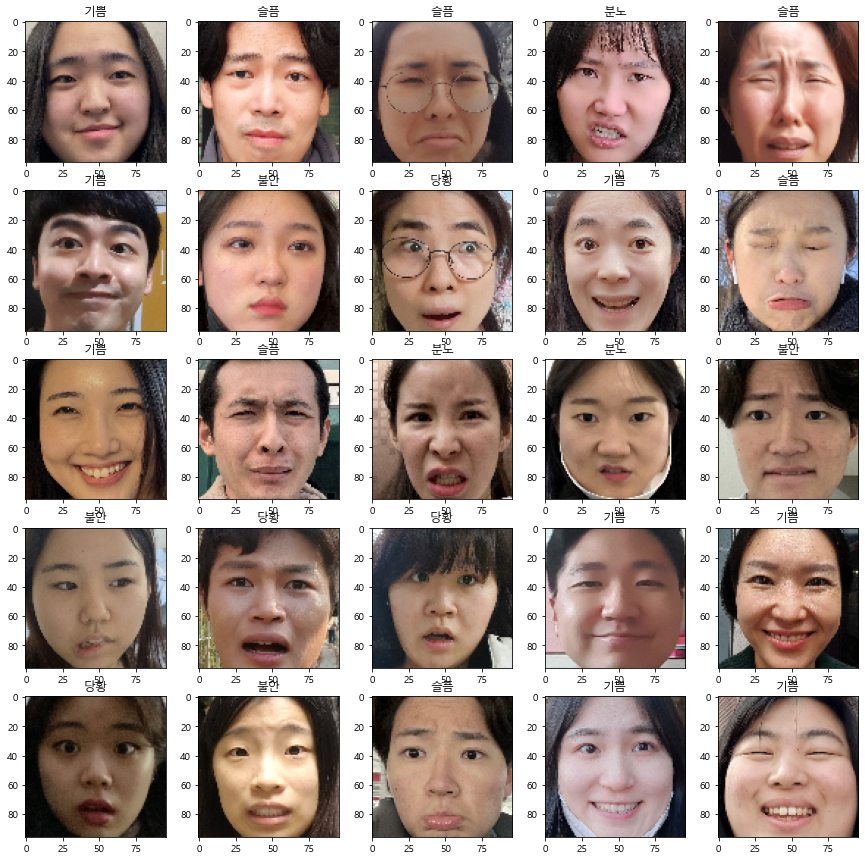

In [47]:
fig, axes = plt.subplots(5,5, figsize=(15,15))
y = np.argmax(yTrain, axis=1)
#fig.subtitle("Anomaly data",fontsize=16)
for i,ax in enumerate(axes.flat):
    tmp = get_value(y[i])
    ax.title.set_text(tmp)
    ax.imshow(xTrain[i])
 

In [15]:
with open('shap_value.p', 'rb') as file: 
    shap_list = pickle.load(file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


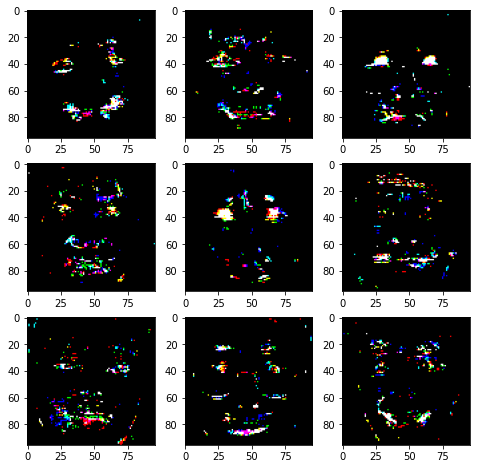

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,3, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(arr[i])

In [13]:
import pickle

with open('train_origin.p', 'wb') as file: 
    pickle.dump(xTrain, file)
    pickle.dump(yTrain, file)
    #pickle.dump(contain_train, file)
    #pickle.dump(labels_train, file)

In [5]:
import pickle

with open('test_origin.p', 'wb') as file: 
    pickle.dump(xTest, file)
    pickle.dump(yTest, file)
    #pickle.dump(container_test, file)
    #pickle.dump(labels_test, file)

In [5]:
#SHAP Value 추출용 가벼운 분류 모델
with tf.device('/gpu:0'):
    model2 = Sequential()
    model2.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(96,96,3)))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Conv2D(128, kernel_size=(5,5),padding='same', activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

#     model2.add(Conv2D(512, kernel_size=(3,3),padding='same', activation='relu'))
#     model2.add(BatchNormalization())
#     model2.add(Activation('relu'))
#     model2.add(MaxPooling2D(pool_size=(2,2)))
#     model2.add(Dropout(0.25))
               
    model2.add(Conv2D(512, kernel_size=(3,3),padding='same', activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.25))

    model2.add(Flatten())
               
    model2.add(Dense(256))
    model2.add(BatchNormalization())               
    model2.add(Activation('relu'))
    model2.add(Dropout(0.25))

#     model2.add(Dense(256))
#     model2.add(BatchNormalization())               
#     model2.add(Activation('relu'))
#     model2.add(Dropout(0.25))
    
    opt = Adam(learning_rate=0.0005)
    model2.add(Dense(5, activation='softmax'))
    model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    history2 = model2.fit(new_x, new_y, 
                      epochs=35, batch_size=50)

Epoch 1/35
548/548 [==============================] - 35s 51ms/step - loss: 1.1991 - accuracy: 0.5152
Epoch 2/35
548/548 [==============================] - 27s 50ms/step - loss: 0.8083 - accuracy: 0.6880
Epoch 3/35
548/548 [==============================] - 28s 50ms/step - loss: 0.6860 - accuracy: 0.7346
Epoch 4/35
548/548 [==============================] - 28s 51ms/step - loss: 0.6175 - accuracy: 0.7615
Epoch 5/35
548/548 [==============================] - 28s 51ms/step - loss: 0.5586 - accuracy: 0.7870
Epoch 6/35
548/548 [==============================] - 27s 50ms/step - loss: 0.5162 - accuracy: 0.8043
Epoch 7/35
548/548 [==============================] - 28s 50ms/step - loss: 0.4714 - accuracy: 0.8219
Epoch 8/35
548/548 [==============================] - 28s 50ms/step - loss: 0.4391 - accuracy: 0.8340
Epoch 9/35
548/548 [==============================] - 28s 50ms/step - loss: 0.4030 - accuracy: 0.8477
Epoch 10/35
548/548 [==============================] - 28s 50ms/step - loss: 0.374

In [15]:
with open('shap_value1.p', 'wb') as file: 
    pickle.dump(shap_list, file)